In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

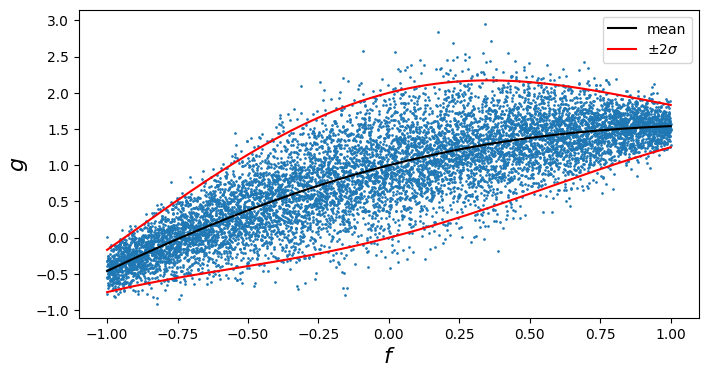

In [2]:
x = np.linspace(-1, 1, 10000)
mu = x + np.cos(x)
sd = 0.5*np.cos(x)**2
y = mu + np.random.normal(0, sd, 10000)

plt.figure(figsize = (8, 4))
plt.scatter(x, y, s = 0.9, c = 'C0')
plt.plot(x, mu, c = 'black', label = 'mean')
plt.plot(x, mu + 2*sd, c = 'red', label = '$\pm 2 \sigma$')
plt.plot(x, mu - 2*sd, c = 'red')
plt.xlabel('$f$', fontsize = 16)
plt.ylabel('$g$', fontsize = 16)
plt.legend()
plt.show()

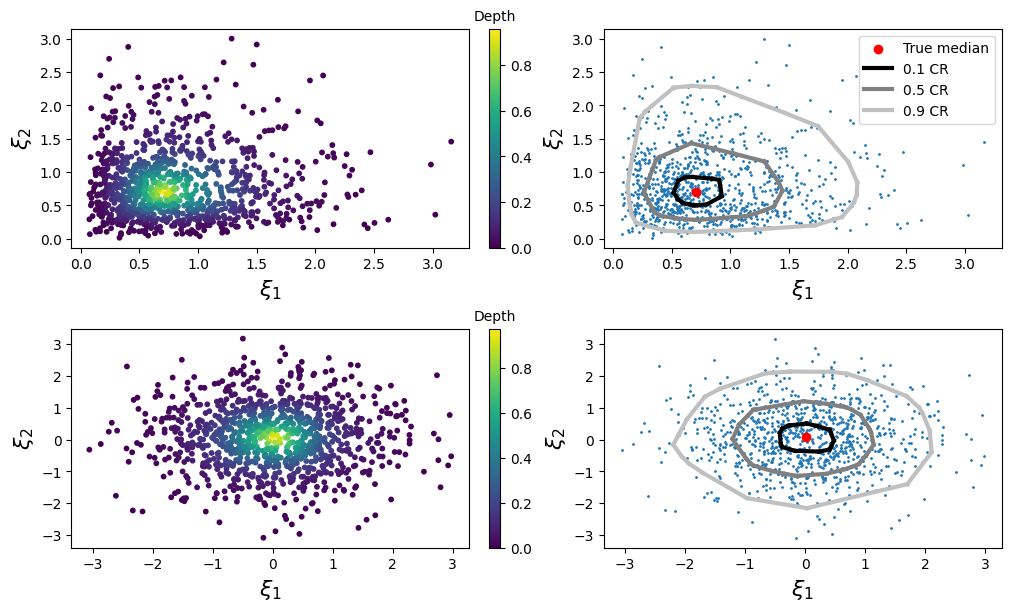

In [284]:
from scipy.spatial import ConvexHull

def tdepth(x0, x):
    f1 = np.mean(x0 > x)
    f2 = np.mean(x0 < x)
    return 2 * np.min([f1, f2])

def int_tdepth(x0, x):
    d1 = tdepth(x0[0], x[:,0])
    d2 = tdepth(x0[1], x[:,1])
    return np.min([d1, d2]) * np.mean([d1, d2])

fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (10, 6))

x1 = np.log(0.99 + np.exp(np.random.normal(0, 1, 1000)))
x2 = np.log(0.99 + np.exp(np.random.normal(0, 1, 1000)))
x = np.stack([x1, x2], axis = 1)
d = [int_tdepth(x[i], x) for i in range(1000)]

# ax[0,0].scatter(x1, x2, c = d, s = 10)
im = ax[0,0].scatter(x1, x2, c = d, s = 10)
clb = plt.colorbar(im, ax=ax[0, 0])
clb.ax.set_title('Depth', fontsize = 10)

ax[0,1].scatter(x1, x2, s = 1)
ax[0,1].scatter(np.median(x1), np.median(x2), c = 'red', label = 'True median')

quants = [0.9, 0.5, 0.1]
# cols = [4, 6, 9]
cols = ['black', 'grey', 'silver']
for j, q in enumerate(quants):
    points = x[d > np.quantile(d, q)]
    hull = ConvexHull(points)
    for i, simplex in enumerate(hull.simplices):
        if i == 0:
            ax[0,1].plot(points[simplex, 0], points[simplex, 1], lw = 3, 
                         c = cols[j], label = f'{np.round(1-q, 1)} CR')
        else:
            ax[0,1].plot(points[simplex, 0], points[simplex, 1], lw = 3, c = cols[j])

ax[0,1].legend()
    
x1 = np.random.normal(0, 1, 1000)
x2 = np.random.normal(0, 1, 1000)
x = np.stack([x1, x2], axis = 1)
d = [int_tdepth(x[i], x) for i in range(1000)]

im = ax[1,0].scatter(x1, x2, c = d, s = 10)
clb = plt.colorbar(im, ax=ax[1, 0])
clb.ax.set_title('Depth', fontsize = 10)
ax[1,1].scatter(x1, x2, s = 1)
ax[1,1].scatter(np.median(x1), np.median(x2), c = 'red')

for j, q in enumerate(quants):
    points = x[d > np.quantile(d, q)]
    hull = ConvexHull(points)
    for i, simplex in enumerate(hull.simplices):
        if i == 0:
            ax[1,1].plot(points[simplex, 0], points[simplex, 1], lw = 3,
                         c = cols[j], label = f'{np.round(1-q, 1)} CR')
        else:
            ax[1,1].plot(points[simplex, 0], points[simplex, 1],  lw = 3, c = cols[j])
            
for i in range(2):
    for j in range(2):
        ax[i,j].set_ylabel('$\\xi_2$', fontsize = 16)
        ax[i,j].set_xlabel('$\\xi_1$', fontsize = 16)

In [191]:
x1 = np.log(0.99 + np.exp(np.random.normal(0, 1, 1000)))
x2 = np.log(0.99 + np.exp(np.random.normal(0, 1, 1000)))
x = np.stack([x1, x2], axis = 1)
d = [int_tdepth(x[i], x) for i in range(1000)]

np.median(x1), np.median(x2)

(np.float64(0.6902469412406722), np.float64(0.6838452346703987))

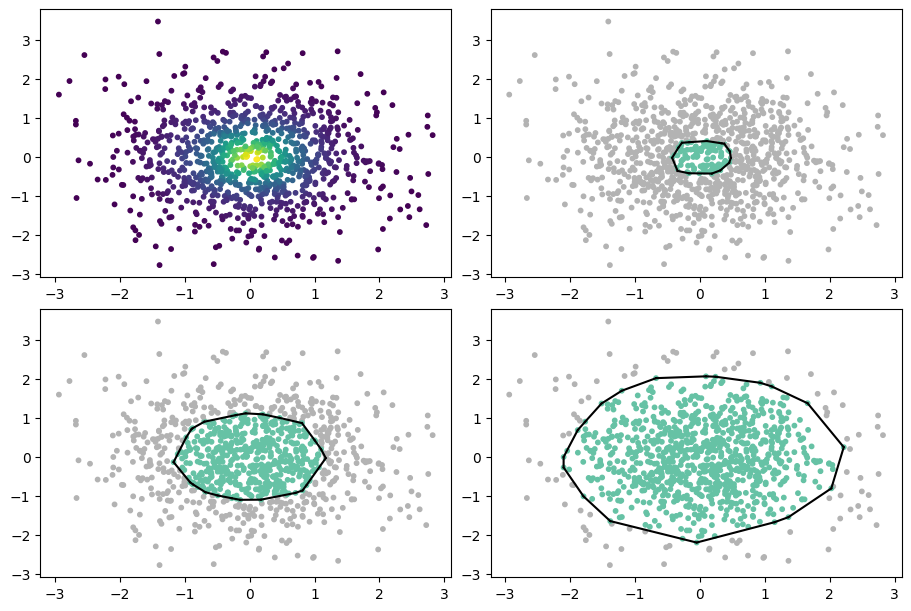

In [168]:
from scipy.spatial import ConvexHull

d = [int_tdepth(x[i], x) for i in range(1000)]

fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize = (9, 6))
ax[0,0].scatter(x1, x2, c = d, s = 10)

ax[0,1].scatter(x1, x2, c = d > np.quantile(d, 0.9), cmap = 'Set2_r', s = 10)
points = x[d > np.quantile(d, 0.9)]
hull = ConvexHull(points)
for simplex in hull.simplices: 
    ax[0,1].plot(points[simplex, 0], points[simplex, 1], 'k-')


ax[1,0].scatter(x1, x2, c = d > np.quantile(d, 0.5), cmap = 'Set2_r', s = 10)
points = x[d > np.quantile(d, 0.5)]
hull = ConvexHull(points)
for simplex in hull.simplices: 
    ax[1,0].plot(points[simplex, 0], points[simplex, 1], 'k-')
    
ax[1,1].scatter(x1, x2, c = d > np.quantile(d, 0.1), cmap = 'Set2_r', s = 10)
points = x[d > np.quantile(d, 0.1)]
hull = ConvexHull(points)
for simplex in hull.simplices: 
    ax[1,1].plot(points[simplex, 0], points[simplex, 1], 'k-')

In [157]:
points = x[d > np.quantile(d, 0.9)]
hull = ConvexHull(points)

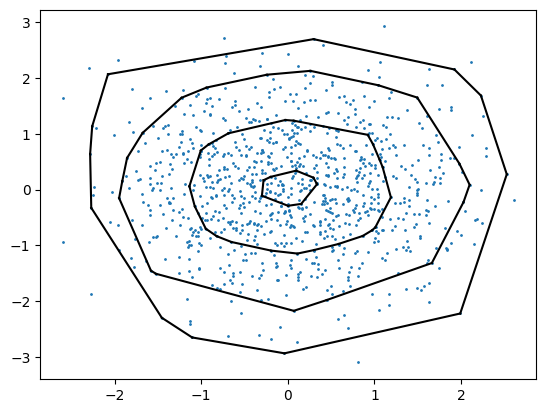

In [158]:
plt.scatter(x1, x2, s = 1)

points = x[d > np.quantile(d, 0.95)]
hull = ConvexHull(points)

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    
points = x[d > np.quantile(d, 0.5)]
hull = ConvexHull(points)

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    
points = x[d > np.quantile(d, 0.1)]
hull = ConvexHull(points)

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    
points = x[d > np.quantile(d, 0.01)]
hull = ConvexHull(points)

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')